In [6]:
# -*- coding: utf-8 -*-
from __future__ import print_function
import cv2 as cv
import numpy as np
import argparse
import matplotlib.pyplot as plt
import time
import cv2
import math
from PIL import Image
plt.rcParams['figure.figsize'] = 15, 10

# 处理填空题

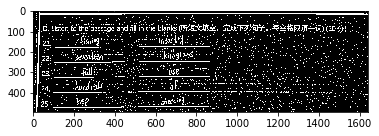

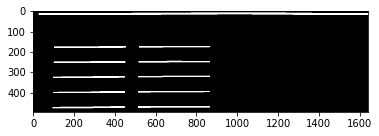

0


IndexError: too many indices for array

In [13]:
# https://www.cnblogs.com/korbin/p/5625340.html
import math
DEBUG = True
img = cv2.imread('/home/hecong/image/fill/fill_1.jpg') 
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img = cv2.GaussianBlur(img,(5,5),0)
# ret,img = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,11,2)

plt.imshow(img,'gray')
plt.show()

cols = img.shape[1]
horizontal_size = int(cols / 40)

# Create structure element for extracting horizontal lines through morphology operations
horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontal_size, 1))
# Apply morphology operations
img = cv2.erode(img, horizontalStructure)
img = cv2.dilate(img, horizontalStructure)

img = cv2.blur(img, tuple((3, 3)))
element = cv2.getStructuringElement(cv2.MORPH_RECT, tuple((5, 5)), (-1, -1))
img = cv2.dilate(img, element, iterations=1)

plt.imshow(img,'gray')
plt.show()


# 扫线最小长度取图片的宽 20%长度
minLineLength = int(img.shape[1] * 0.3)
lines = cv2.HoughLinesP(img, 1, np.pi / 180, 20, minLineLength=minLineLength, maxLineGap=30)


imgcanv = Image.new("RGB", (img.shape[1], img.shape[0]), (255, 255, 255))
imgcanv = np.array(imgcanv)
lines = lines[:,0,:]
exmr = []
for line in lines:
    x1, y1, x2, y2 = line
    width = abs(x2-x1)
    hight = abs(y2-y1)
    x1,y1,width,hight = int(10*round(x1/10)), int(10*round(y1/10)), int(10*round(width/10)), int(10*round(hight/10))
    if int(100 * width/img.shape[1]) <= 30 and int(100 * width/img.shape[1]) >= 20:
        # 进行四舍五入操作,为后期排重做准备
        exmr.append([x1,y1,width,hight,int(100 * width/img.shape[1])])
        
exmr = np.array(exmr)
print(len(exmr))
# 根据Y轴进行排重
va,inx = np.unique(exmr[:,1] + exmr[:,0],return_index=True)
exmr = exmr[inx]

# exmr = exmr[exmr[:,2]>200]
idex = np.lexsort([exmr[:, 0], exmr[:, 1]])


exmr = exmr[idex,:]
# cidx = [0,3,4,6,9,10,11,14,16,18,20]
# exmr = exmr[cidx,:]

# print(exmr)
if DEBUG:
    for item in exmr:
        x1,y1,w,h,s = item
        cv2.line(imgcanv, (x1, y1), (x1+w, y1+h), (120, 120, 120), 2)
        
if DEBUG:
#     logger.debug('调试，显示划线图')
    plt.imshow(imgcanv,'gray')
    plt.show()

print(exmr)
# plt.imshow(img,'gray')
# plt.show()
# print(exmr)

In [11]:

# 根据Y轴取维一的值 
# print(exmr)
v = np.unique(exmr[:,1])
print(v[1:])
# 去掉Y轴相近的值，得到分组的基本值
vv = [x for i,x in enumerate(v[1:]) if abs(x-v[i])> 10 ]
vv.insert(0,v[0])
print(vv)
# 根据分组的基本值，得到相应的索引位值,  再对比X轴的值，去掉相近的值
groups = []
for item in vv:
    idx =np.where(abs(exmr[:,1]-item) <= 10)[0]
    if(len(idx)>1):
        # 因为X轴已按从小到大排序，所以可以利用其特点按序进行检测
        xidxs = [idx[0]]
#         current = idx[0]
        for xitem in idx[1:]:
            
            if np.all(abs(exmr[xidxs,0] - exmr[xitem,0]) > 20):
                xidxs.append(xitem)
                current = xitem
        
        groups.append([item,xidxs])
    else:
        groups.append([item,idx.tolist()])

print(groups)

gp = [x[1] for x in groups]
print(gp)
cc = np.array(gp)
# print(cc.reshape(-1))
# cidx = [0,3,4,6,9,10,11,14,16,18,20]
# print(exmr)
# print(exmr[cidx])



[ 30 170 180 190 240 250 260 310 320 330 340 390 400 410 460 470 480]
[10, 30, 170, 240, 310, 390, 460]
[[10, [0]], [30, [1, 2, 4, 5, 6, 7]], [170, [8, 11]], [240, [20, 22]], [310, [30, 32, 33, 35]], [390, [38]], [460, [47, 48, 49, 51, 53]]]
[[0], [1, 2, 4, 5, 6, 7], [8, 11], [20, 22], [30, 32, 33, 35], [38], [47, 48, 49, 51, 53]]


# 识别试卷中心区域

[[[ 67 102 116]
  [ 66 101 115]
  [ 65 100 114]
  ...
  [104 128 140]
  [104 128 140]
  [103 127 139]]

 [[ 67 102 116]
  [ 66 101 115]
  [ 66 101 115]
  ...
  [103 127 139]
  [103 127 139]
  [104 128 140]]

 [[ 67 102 116]
  [ 67 102 116]
  [ 67 102 116]
  ...
  [102 126 138]
  [103 127 139]
  [104 128 140]]

 ...

 [[  2   9   6]
  [  2   9   6]
  [  2   9   6]
  ...
  [ 14  26  26]
  [ 15  27  27]
  [ 15  27  27]]

 [[  2   9   6]
  [  2   9   6]
  [  2   9   6]
  ...
  [ 14  26  26]
  [ 15  27  27]
  [ 16  28  28]]

 [[  3  10   7]
  [  3  10   7]
  [  3  10   7]
  ...
  [ 15  27  27]
  [ 15  27  27]
  [ 16  28  28]]]


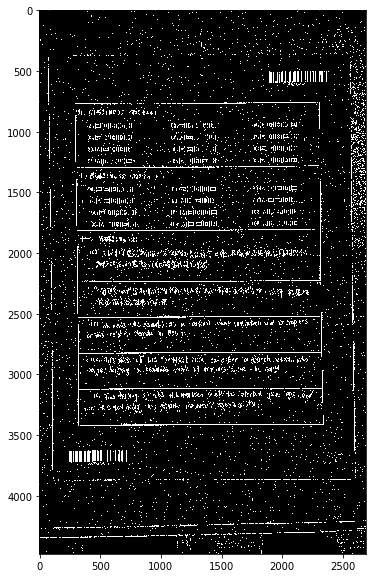

56004
[5336004.5, 1159832.5, 1980428.5, 2057753.0]


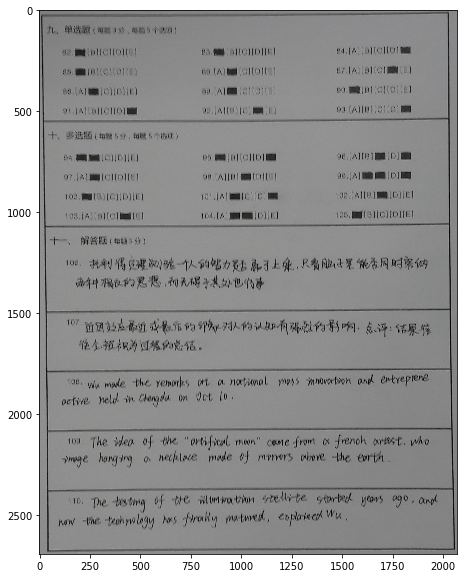

In [10]:
# https://blog.csdn.net/keith_bb/article/details/53470170?utm_source=blogxgwz0  华为荣耀V10 小米max1
path = 'D:/WechatIMG71.jpeg'
imgage = cv2.imread(path,cv2.IMREAD_COLOR)
print(imgage)
img = cv2.cvtColor(imgage,cv2.COLOR_BGR2GRAY)
img = cv2.GaussianBlur(img,(5,5),0)
# ret,img = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,11,2)
# img = cv2.blur(img,tuple((5,5)))
plt.imshow(img,'gray')
plt.show()
nimg, contours, hierarchy = cv2.findContours(
    img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))
rcnt = []
rarea = []
for cnt in contours:
    if cv2.contourArea(cnt) > 40000:
        rarea.append(cv2.contourArea(cnt))
        rcnt.append(cnt)
print(rarea)        
pos = np.argmax(rarea)        
cnt = rcnt[pos]
x,y,w,h = cv2.boundingRect(cnt)
# cv2.rectangle(imgage,(x,y),(x+w,y+h),0,-1)
# plt.imshow(imgage,'brg')
# plt.show()
x = x-10
w = w + 20
y = y - 10
h = h + 20
crop_img = imgage[y:y+h, x:x+w]
cv2.imwrite('/home/hecong/image/fill/crop.jpg',crop_img)
plt.imshow(crop_img,'brg')
plt.show()

# 识别试卷边框

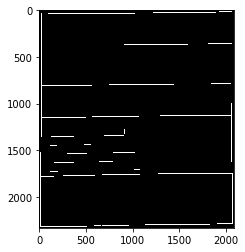

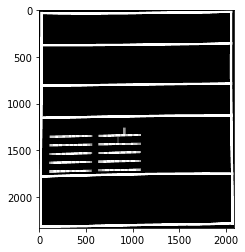

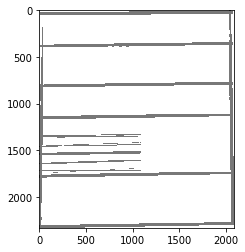

In [12]:
DEBUG = True

def _get_rect(image):
        image = cv2.blur(image, tuple((5, 5)))
        element = cv2.getStructuringElement(cv2.MORPH_RECT, tuple((21, 21)), (-1, -1))
        imgr = cv2.dilate(image, element, iterations=1)
        if DEBUG:
#             logger.debug('调试，显示处理后合并图')
            plt.imshow(imgr,'gray')
            plt.show()

        lines = cv2.HoughLinesP(imgr, 1, np.pi / 180, 20, minLineLength=1000, maxLineGap=80)
        if DEBUG:
            imgt = Image.new("RGB", (imgr.shape[1], imgr.shape[0]), (255, 255, 255))
            imgt = np.array(imgt)
        lines = lines[:,0,:]
        exmr = []
        for line in lines:
            x1, y1, x2, y2 = line
            if DEBUG:
                cv2.line(imgt, (x1, y1), (x2, y2), (120, 120, 120), 2)
            width = abs(x2-x1)
            hight = abs(y2-y1)
            exmr.append([x1,y1,width,hight, sum((x1,y1,hight,width))])

        if DEBUG:
#             logger.debug('调试，显示划线图')
            plt.imshow(imgt,'gray')
            plt.show()

    



imgage = cv2.imread('/home/hecong/image/fill/crop.jpg',cv2.IMREAD_COLOR)
img = cv2.cvtColor(imgage,cv2.COLOR_BGR2GRAY)
img = cv2.GaussianBlur(img,(5,5),0)
# ret,img = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,11,2)  # 11, 2 这两个参数有什么用 ？？

horizontal = np.copy(img)
vertical = np.copy(img)

cols = horizontal.shape[1]
horizontal_size = int(cols / 40)

# Create structure element for extracting horizontal lines through morphology operations
horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontal_size, 1))
# Apply morphology operations
horizontal = cv2.erode(horizontal, horizontalStructure)
horizontal = cv2.dilate(horizontal, horizontalStructure)

rows = vertical.shape[0]
verticalsize = int(rows / 40)
# Create structure element for extracting vertical lines through morphology operations
verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (1, verticalsize))

# Apply morphology operations
vertical = cv2.erode(vertical, verticalStructure)
vertical = cv2.dilate(vertical, verticalStructure)

nn = cv2.bitwise_or(vertical,horizontal)
plt.imshow(nn,'gray')
plt.show()

_get_rect(nn)


# 识别试卷边框二

In [11]:
DEBUG = True

def _get_rect(image):
    image = cv2.blur(image, tuple((5, 5)))
    element = cv2.getStructuringElement(cv2.MORPH_RECT, tuple((21, 21)), (-1, -1))
    imgr = cv2.dilate(image, element, iterations=1)
    if DEBUG:
#             logger.debug('调试，显示处理后合并图')
        plt.imshow(imgr,'gray')
        plt.show()

    nimg, contours, hierarchy = cv2.findContours(imgr, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours
        
imgage = cv2.imread('/home/hecong/image/fill/crop.jpg',cv2.IMREAD_COLOR)
img = cv2.cvtColor(imgage,cv2.COLOR_BGR2GRAY)
img = cv2.GaussianBlur(img,(5,5),0)
# ret,img = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,11,2)  # 11, 2 这两个参数有什么用 ？？

horizontal = np.copy(img)
vertical = np.copy(img)

cols = horizontal.shape[1]
horizontal_size = int(cols / 30)

# Create structure element for extracting horizontal lines through morphology operations
horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontal_size, 1))
# Apply morphology operations
horizontal = cv2.erode(horizontal, horizontalStructure)
horizontal = cv2.dilate(horizontal, horizontalStructure)
plt.imshow(horizontal,'gray')
plt.show()
length = imgage.shape[1]
contours = _get_rect(horizontal)

error: OpenCV(3.4.1) C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:11147: error: (-215) scn == 3 || scn == 4 in function cv::cvtColor


In [24]:
cnts = []
# print(contours)
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    if w > int(length*0.9):
        cnts.append([y,x,h,w])

cnts = np.array(cnts)
idex = np.lexsort([cnts[:, 1], cnts[:, 0]])
cnts = cnts[idex,:]
print(cnts)


[[   2    4  143 2575]
 [ 705   12   71 2550]
 [1589   29   48 2512]
 [2671   44   89 2471]]
